In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import numpy as np

In [26]:
data = pd.read_excel('./assets/Data2.xlsx')
data

Year  Pre_deepawali  Deepawali
0   2003             66         89
1   2004             66         74
2   2005             62         78
3   2006             65         73
4   2007             66         71
..   ...            ...        ...
67  2016             43          0
68  2017             55         69
69  2018             43         75
70  2019             49         68
71  2020             55         57

[72 rows x 3 columns]

In [27]:
plt.figure(dpi=300)
plt.scatter(data['Year'], data['Pre_deepawali'], c="green", label="Pre Deepawali")
plt.scatter(data['Year'], data['Deepawali'], c='red', label="Deepawali")
plt.legend(loc="upper right")
plt.ylabel("Noise Level")
plt.xlabel("Year")
plt.xticks(list(range(2002, 2021)), rotation=45)
plt.ylim(bottom=40, top=100)
plt.title("Full Data Visualization")
plt.show()

In [28]:
corr = data.corr()
print(corr)
plt.figure(dpi=300)
sb.heatmap(corr, annot=True).set_title("Correlation Between Variables")

                   Year  Pre_deepawali  Deepawali
Year           1.000000      -0.131898  -0.097579
Pre_deepawali -0.131898       1.000000   0.669230
Deepawali     -0.097579       0.669230   1.000000


Text(0.5, 1.0, 'Correlation Between Variables')

# 1. Bayesian Ridge Regression
- Guessing `Deepwali` noise level with `Pre Deepawali` noise level

In [29]:
from sklearn.linear_model import BayesianRidge

data = pd.read_excel('./assets/Data2.xlsx')

# Initializing model
bay_ridge = BayesianRidge()

bay_ridge_data = data.loc[:, ['Year', 'Pre_deepawali']]

tempx = np.array(bay_ridge_data.loc[:, 'Year'])

# Spliting data into `training` and `testing`
X_train, X_test, y_train, y_test = train_test_split(tempx.reshape(-1, 1), data['Deepawali'], test_size=0.6)

# Training model with `training` data
bay_ridge.fit(X_train, y_train)

print("%.2f"%bay_ridge.score(X_train, y_train))

pred = bay_ridge.predict(X_test)

x_axis = range(len(y_test))

plt.figure(dpi=300)
plt.scatter(X_test, y_test, s=5, color="blue", label="Original")
plt.plot(X_test, pred, lw=0.8, color="red", label="Predicted")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Deepawali")
plt.title("Bayesian Ridge Regression")
plt.show()

0.00


# 2. Huber Regression

[101.82241664  87.96433341  91.65982227  87.0404612   85.19271677
  89.81207784  88.88820563  89.81207784  94.43143892  94.43143892
  92.58369449  19.59778952  89.81207784  89.81207784  87.96433341
  83.34497234  83.34497234  85.19271677  94.43143892  99.97467221
 101.82241664  98.12692778  99.97467221  98.12692778  95.35531113
  98.12692778 103.67016106  87.0404612   96.27918335  96.27918335
  92.58369449  99.05079999  88.88820563  87.96433341  82.42110013
  86.11658898  91.65982227  92.58369449  90.73595006  89.81207784
  91.65982227  89.81207784  87.96433341  94.43143892  94.43143892
  93.5075667   94.43143892  93.5075667   99.05079999  87.96433341
  83.34497234  87.96433341  84.26884456  84.26884456  19.59778952
  95.35531113  90.73595006  93.5075667   19.59778952  89.81207784
  87.96433341  85.19271677  88.88820563  88.88820563  87.0404612
  85.19271677  87.96433341  19.59778952  83.34497234  88.88820563
  82.42110013  72.25850576]


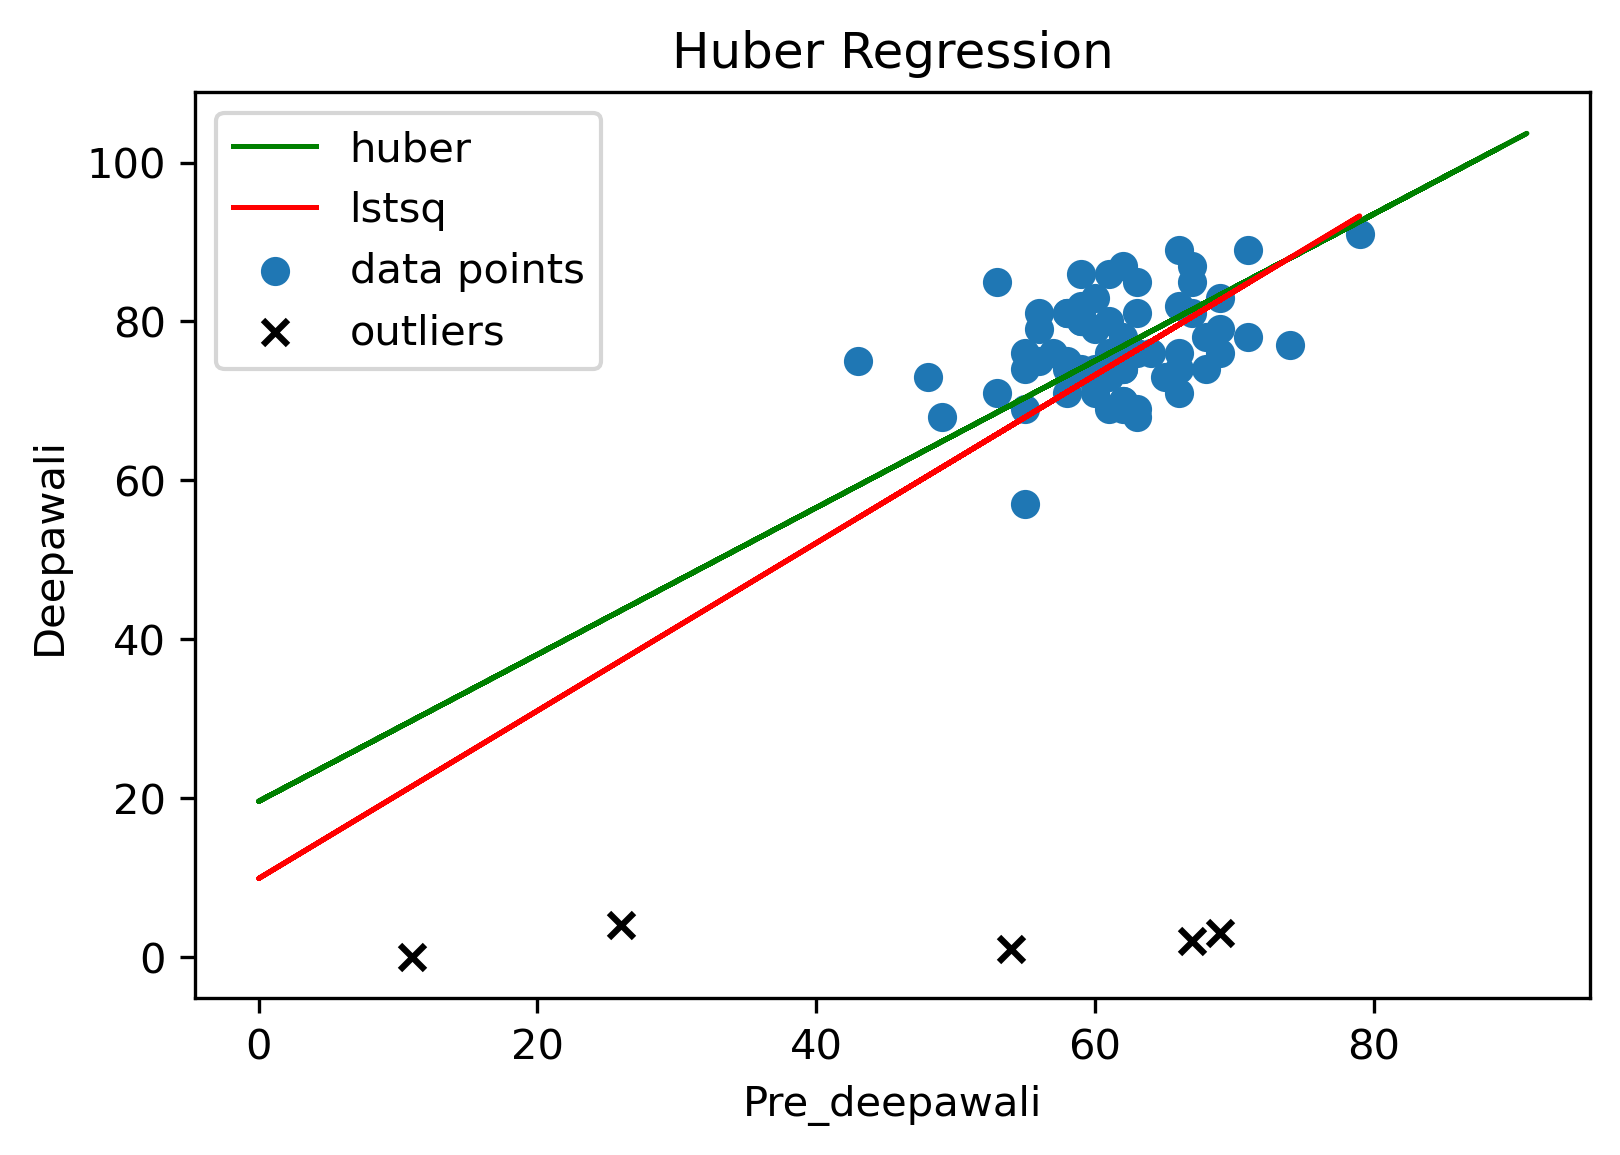

In [30]:
from sklearn.linear_model import HuberRegressor

data = pd.read_excel('./assets/Data2.xlsx')

huber_reg_model = HuberRegressor()

huber_reg_model.fit(data.Pre_deepawali.values.reshape(-1, 1), data.Deepawali)

pred = huber_reg_model.predict(data.Deepawali.values.reshape(-1, 1))

plt.figure(dpi=300)
plt.plot(data.Deepawali, pred, c='g', label="huber", linewidth=1.2);print(pred)

A = np.vstack([data.Pre_deepawali.values, np.ones(len(data.Pre_deepawali))]).T
m, c = np.linalg.lstsq(A, data.Deepawali, rcond=None)[0]
plt.plot(data.Pre_deepawali, m*data.Pre_deepawali + c, 'r', label='lstsq', linewidth=1.2)

Q1 = np.percentile(data['Pre_deepawali'], 25, interpolation = 'midpoint')
 
Q3 = np.percentile(data['Pre_deepawali'], 75, interpolation = 'midpoint')
IQR = Q3 - Q1
upper = data['Pre_deepawali'] >= (Q3+1.5*IQR)
lower = data['Pre_deepawali'] <= (Q1-1.5*IQR)

outliers = np.hstack([np.where(lower), np.where(upper)]).flatten()

data[data.Deepawali < 40] = None
plt.scatter(data.Pre_deepawali, data.Deepawali, label="data points")
plt.scatter(outliers, range(len(outliers)), marker='x',c='black', label="outliers")
plt.xlabel("Pre_deepawali")
plt.ylabel("Deepawali")
plt.title("Huber Regression")
plt.legend()


# 3. Quantile Regression

In [31]:
import statsmodels.formula.api as smf

data = pd.read_excel('./assets/Data2.xlsx')

mod = smf.quantreg('Deepawali ~ Year', data) 
res = mod.fit(q=.5) 
print(res.summary())

quantiles = np.array([0.05, 0.25, 0.5, 0.75, 0.95])
models = [] 
params = []  
for qt in quantiles:  
    res = mod.fit(q = qt )    
    models.append(res)   
    params.append([qt, res.params['Intercept'], res.params['Year']] + res.conf_int().loc['Year'].tolist())   
    params = pd.DataFrame(data = params, columns = ['qt','intercept','x_coef','cf_lower_boun','cf_upper_bound'])
    # print(params)

plt.figure(dpi=300) 
plt.scatter(data.Year, data.Deepawali,  color='black') 

y_pred1 = models[0].params['Intercept'] + models[0].params['Year'] * data.Year 
plt.plot(data.Year, y_pred1, color='red', linewidth=2, label='Q Reg : 0.05') 

y_pred2 = models[1].params['Intercept'] + models[1].params['Year'] * data.Year 
plt.plot(data.Year, y_pred2, color='green', linewidth=2, label='Q Reg : 0.25')

y_pred3 = models[2].params['Intercept'] + models[2].params['Year'] * data.Year 
plt.plot(data.Year, y_pred3, color='cyan', linewidth=2, label='Q Reg : 0.50') 

y_pred4 = models[3].params['Intercept'] + models[3].params['Year'] * data.Year 
plt.plot(data.Year, y_pred4, color='blue', linewidth=2, label='Q Reg : 0.75') 

y_pred5 = models[4].params['Intercept'] + models[4].params['Year'] * data.Year 
plt.plot(data.Year, y_pred5, color='pink', linewidth=2, label='Q Reg : 0.95') 
 
plt.ylabel("y and predicted y") 
plt.xlabel("Year")
plt.title("Quantile Regression") 
plt.legend()

                         QuantReg Regression Results                          
Dep. Variable:              Deepawali   Pseudo R-squared:              0.06804
Model:                       QuantReg   Bandwidth:                       6.980
Method:                 Least Squares   Sparsity:                        15.57
Date:                Sun, 07 Aug 2022   No. Observations:                   72
Time:                        22:18:31   Df Residuals:                       70
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    989.9090    355.816      2.782      0.007     280.257    1699.561
Year          -0.4545      0.177     -2.570      0.012      -0.807      -0.102

The condition number is large, 7.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.


/home/om/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/tmp/ipykernel_136643/1782810946.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params.append([qt, res.params['Intercept'], res.params['Year']] + res.conf_int().loc['Year'].tolist())
/tmp/ipykernel_136643/1782810946.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params.append([qt, res.params['Intercept'], res.params['Year']] + res.conf_int().loc['Year'].tolist())
/tmp/ipykernel_136643/1782810946.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params.append([qt, res.params['Inter

# 3. Linear Regression

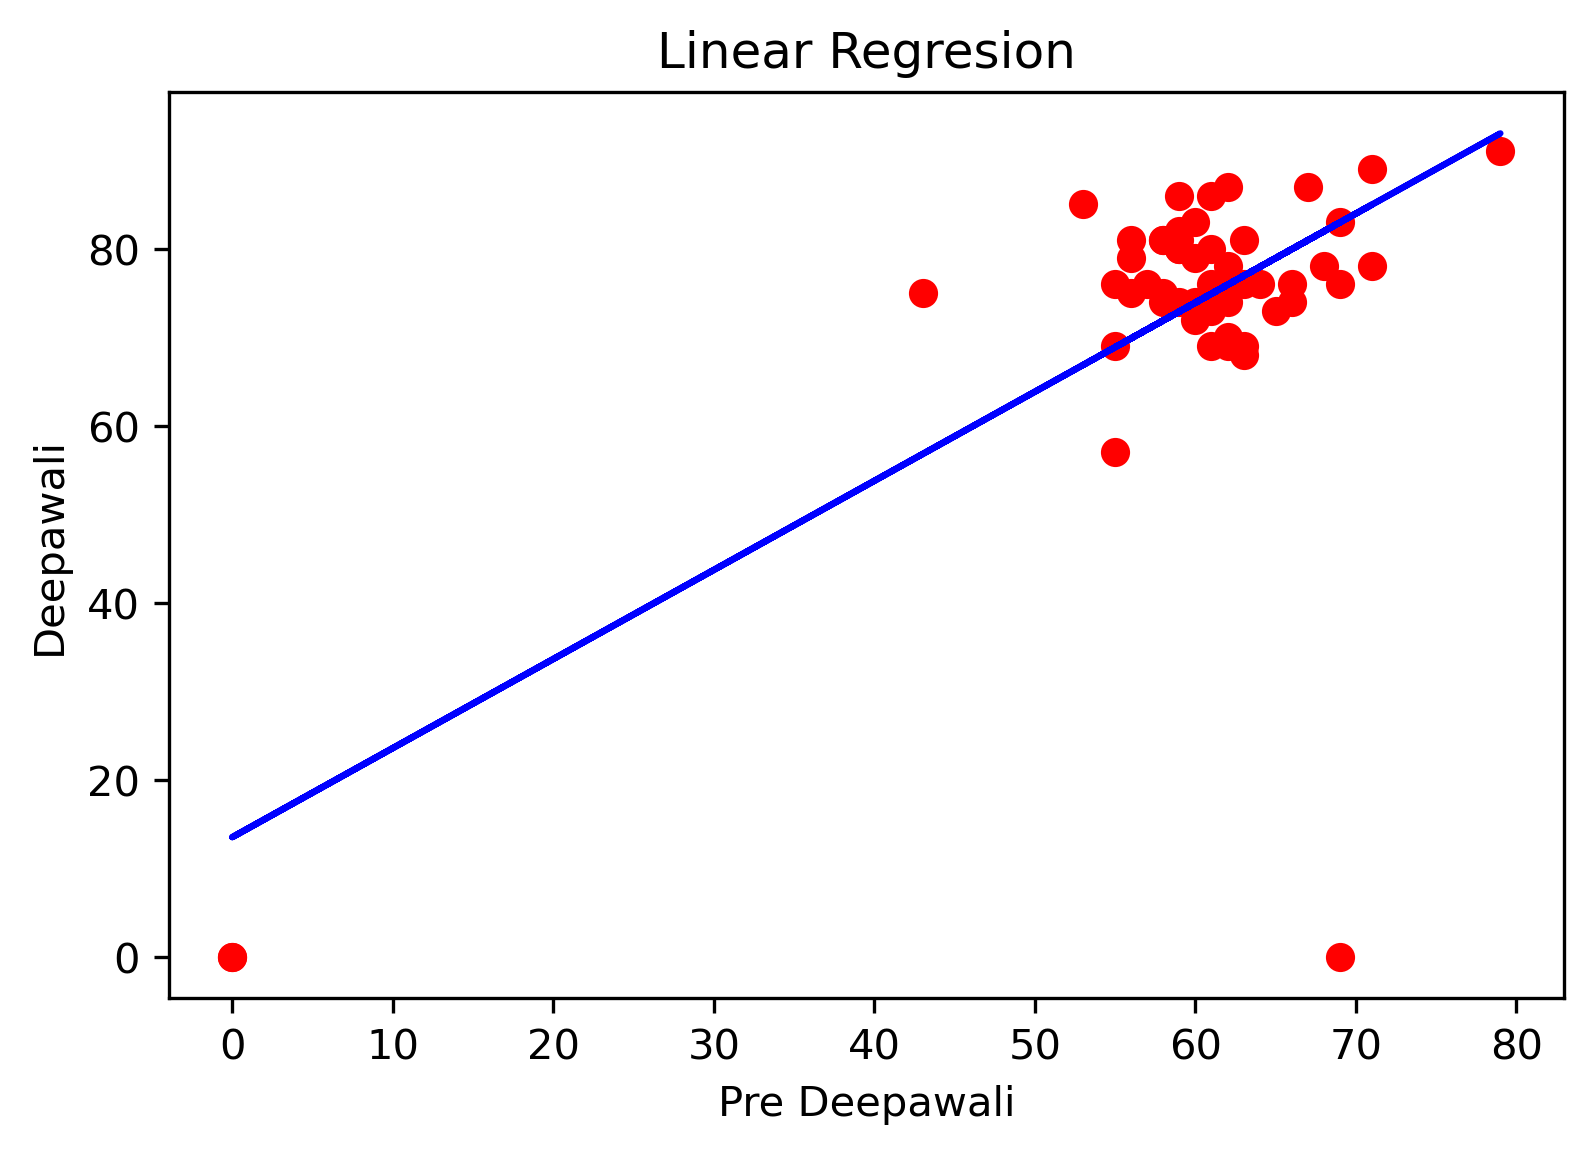

In [32]:
data = pd.read_excel("./assets/Data2.xlsx")

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg_data = data.loc[:, ['Year', 'Pre_deepawali']]

tempx = np.array(lin_reg_data.loc[:, 'Pre_deepawali'])

X_train, X_test, y_train, y_test = train_test_split(tempx.reshape(-1, 1), data['Deepawali'], test_size=0.25)

lin_reg.fit(X_train, y_train)
plt.figure(dpi=300)
plt.scatter(X_train, y_train, color='red')
plt.plot(X_train, lin_reg.predict(X_train), color='blue')
plt.title('Linear Regresion')
plt.xlabel('Pre Deepawali')
plt.ylabel('Deepawali')
plt.show()

# 5. Logistic Regression

In [33]:
data = pd.read_excel("./assets/Data2.xlsx")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def logistic(x, x0, k, L):
    return L/(1+np.exp(-k*(x-x0)))

log_model = LogisticRegression(max_iter=10000, n_jobs=-1)

log_data = data.loc[:, ['Year', 'Pre_deepawali']]

tempx = np.array(log_data.loc[:, 'Pre_deepawali'])

X_train, X_test, y_train, y_test = train_test_split(tempx.reshape(-1, 1), data['Deepawali'], test_size=0.5)

plt.figure(dpi=300)
plt.scatter(data["Deepawali"], [1]*len(data["Deepawali"]), s=20, c="green")
plt.scatter(data["Pre_deepawali"], [0]*len(data["Pre_deepawali"]), s=20, c="red")
plt.yticks([0, 1], ["Deepawali", "Pre_deepawali"], fontsize=12)
plt.xlabel("Noise Level")

x = np.arange(39, 91, 0.5)
l = logistic(x, x0=65, k=0.5, L=1)
plt.plot(x,l, 'k:')
# plt.xlim(20, 100)
plt.title("Logistic Regression", fontsize=20)
plt.show()

log_model.fit(X_train, y_train)
prediction = log_model.predict(np.array(X_train).reshape(-1, 1))
print(accuracy_score(prediction, y_train))
print(f"Prediction : {log_model.predict(np.array([66]).reshape(-1,1))}")

0.19444444444444445
Prediction : [78]
